In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz

q_range = np.arange(95, 113, 0.001)

# Generate fuzzy membership functions
m1 = fuzz.trapmf(q_range, [95, 95, 106.2, 107.4])
m2 = fuzz.trimf(q_range, [106.2, 107.4, 108])
m3 = fuzz.trimf(q_range, [107.4, 108, 109.2])
m4 = fuzz.trapmf(q_range, [108, 109.2, 113, 113])

plt.plot(q_range, m1, 'b', linewidth=1.5, label='Very Low')
plt.plot(q_range, m2, 'g', linewidth=1.5, label='Low')
plt.plot(q_range, m3, 'r', linewidth=1.5, label='Very Low')
plt.plot(q_range, m4, 'c', linewidth=1.5, label='High')
plt.grid()
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
fuzz.interp_membership(q_range, m1, 98)
fuzz.interp_membership(q_range, m2, 98)
fuzz.interp_membership(q_range, m3, 98)
fuzz.interp_membership(q_range, m4, 98)

0.0

In [3]:
from scipy.integrate import solve_ivp
import numpy as np


def dec_ode(u):
    def ode_eqn(t, z):
        qc = u
        q = 100
        Cao = 1
        To = 350
        Tco = 350
        V = 100
        hA = 7e5
        ko = 7.2e10
        AE = 1e4
        delH = 2e5
        rho = 1e3
        rhoc = 1e3
        Cp = 1
        Cpc = 1
        Ca = z[0]
        T = z[1]
        f1 = (q / V * (Cao - Ca)) - (ko * Ca * np.exp(-AE / T))
        f2 = (
            (q / V * (To - T))
            - ((((-delH) * ko * Ca) / (rho * Cp)) * np.exp(-AE / T))
            + (((rhoc * Cpc) / (rho * Cp * V)) * qc * (1 - np.exp(-hA / (qc * rho * Cp))) * (Tco - T))
        )
        return [f1, f2]

    return ode_eqn

def get_init_states(u):
    Tbar = 438.86881957
    ybar = 0.09849321
    t_span = np.linspace(0, 10, 100)
    sol = solve_ivp(dec_ode(u), t_span=[t_span[0], t_span[-1]], y0=[ybar, Tbar])
    return sol.y[0][-1], sol.y[1][-1]

In [4]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import *
from gym import spaces
from scipy.integrate import solve_ivp
from simple_pid import PID
import os
import cv2
import io

uinit = 103.0
umin = 95.0
umax = 113.0
Tbar = 438.86881957
ybar = 0.09849321
yinit, Tinit = get_init_states(uinit)
delt = 0.083
slew_rate = 20.0

Kp = 125.0
taui = 0.3367
taud = 0.19
Ki = Kp / taui
Kd = Kp * taud

disturbance=True
deterministic=False

def fig2data(fig, dpi=72):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @param dpi DPI of saved image
    @return a numpy 3D array of RGBA values
    """
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


class CSTR:
    def __init__(
        self,
        uinit=uinit,
        Tinit=Tinit,
        yinit=yinit,
        delt=delt,
        ttfinal=None,
        disturbance=disturbance,
        deterministic=deterministic,
    ):
        # Simulation settings
        self.delt = delt  # sample time
        self.ttfinal = ttfinal  # final simulation time
        self.ksp = 10
        self.slew_rate = slew_rate
        self.umin = umin
        self.umax = umax
        self.input_low = np.array([self.umin])
        self.input_high = np.array([self.umax])

        #  plant initial conditions
        self.uinit = uinit
        self.Tinit = Tinit
        self.yinit = yinit

        self.disturbance = disturbance
        self.deterministic = deterministic
        self.reset()

    @property
    def state_names(self):
        names = names = ["Setpoint(k)", "Output(k)", "Output(k-1)", "Temp(k)", "Temp(k-1)", "Model Region(k)"]
        assert len(names) == self.n_states
        return names

    @property
    def input_names(self):
        names = ["Input(k)"]
        assert len(names) == self.n_actions
        return names

    @property
    def n_states(self):
        return len(self.get_state())

    @property
    def n_actions(self):
        return self.input_low.shape[0]

    def reset(self):
        if self.deterministic:
            self.r = np.concatenate(
                (
                    np.ones((self.ksp, 1)) * self.yinit,
                    np.ones((40, 1)) * 0.11038855,
                    np.ones((30, 1)) * 0.08823159,
                    np.ones((40, 1)) * 0.09849321,
                )
            )
        else:
            self.uinit = np.random.randint(102.0, 112.0)
            self.yinit, self.Tinit = get_init_states(self.uinit)
            self.r = np.concatenate(
                (
                    np.ones((self.ksp, 1)) * self.yinit,
                    np.ones((40, 1)) * np.random.uniform(0.07, 0.13),
                    np.ones((30, 1)) * np.random.uniform(0.07, 0.13),
                    np.ones((40, 1)) * np.random.uniform(0.07, 0.13),
                )
            )
        sim_time = len(self.r) * self.delt
        self.ttfinal = self.ttfinal if self.ttfinal is not None and self.ttfinal < sim_time else sim_time
        self.tt = np.arange(0, self.ttfinal, self.delt)  # time vector
        self.kfinal = len(self.tt)  # number of time intervals
        return self.reset_input()

    def reset_input(self):
        # Input vector
        self.input = np.zeros((self.kfinal + 1, self.n_actions))
        self.input[: self.ksp] = np.ones((self.ksp, 1)) * self.uinit
        return self.reset_env()

    def reset_env(self):
        # Reset sim time
        self.tinitial = 0
        self.tfinal = self.tinitial + self.delt
        self.k = self.ksp - 1
        # Input vector
        self.u = np.zeros((self.kfinal + 1, 1))
        self.u[: self.ksp] = np.ones((self.ksp, 1)) * self.uinit
        self.du = np.zeros((self.kfinal, 1))
        # Output vector
        self.y = np.zeros((self.kfinal + 1, 1))
        self.y[: self.ksp] = np.ones((self.ksp, 1)) * self.yinit
        # Temperature Vector
        self.T = np.zeros((self.kfinal + 1, 1))
        self.T[: self.ksp] = np.ones((self.ksp, 1)) * self.Tinit
        # Error vector
        self.E = np.zeros((self.kfinal, 1))
        # State Vector
        self.x = [self.yinit, self.Tinit]
        # Model Vector
        self.m = np.zeros((self.kfinal + 1, 1))
        self.m[: self.ksp] = np.ones((self.ksp, 1)) * self.get_model_region()
        return self.r[self.k][0], self.y[self.k][0]

    def dec_ode(self, u):
        def ode_eqn(t, z):
            qc = u
            q = 100.0
            Cao = 1.0
            To = 350.0
            Tco = 350.0
            V = 100.0
            hA = 7e5
            ko = 7.2e10
            AE = 1e4
            delH = 2e5
            rho = 1e3
            rhoc = 1e3
            Cp = 1.0
            Cpc = 1.0
            Ca = z[0]
            T = z[1]
            Ca = np.maximum(1e-6, Ca)
            T = np.maximum(10, T)
            qc = np.maximum(1e-4, qc)
            try:
                f1 = (q / V * (Cao - Ca)) - (ko * Ca * np.exp(-AE / T))
                f2 = (
                    (q / V * (To - T))
                    - ((((-delH) * ko * Ca) / (rho * Cp)) * np.exp(-AE / T))
                    + (((rhoc * Cpc) / (rho * Cp * V)) * qc * (1 - np.exp(-hA / (qc * rho * Cp))) * (Tco - T))
                )
            except RuntimeWarning:
                print("qc: ", qc)
                print("Ca: ", Ca)
                print("T: ", T)
                raise RuntimeError
            return [f1, f2]

        return ode_eqn

    def step_env(self, u):
        self.E[self.k] = self.r[self.k][0] - self.y[self.k][0]
        # Slew rate
        if self.slew_rate:
            u = np.clip(u, self.u[self.k - 1] - self.slew_rate, self.u[self.k - 1] + self.slew_rate)
        # Disturbance
        d = 0.05 * np.random.randn() if self.disturbance else 0.0
        self.u[self.k] = u + d
        # Control Constraints
        self.u[self.k] = np.clip(self.u[self.k], self.umin, self.umax)
        # Solve ODE and update state vector and output vector
        sol = solve_ivp(self.dec_ode(self.u[self.k]), [self.tinitial, self.tfinal], self.x)
        self.x[0] = sol.y[0][-1]
        self.x[1] = sol.y[1][-1]
        self.y[self.k + 1] = self.x[0]
        self.T[self.k + 1] = self.x[1]
        # Current model region
        self.m[self.k] = self.get_model_region()
        # Update time and sampling instant
        self.tinitial = self.tfinal
        self.tfinal += self.delt
        self.k = self.k + 1
        return self.r[self.k][0], self.y[self.k][0]

    def step(self, u):
        self.input[self.k] = np.array(u)
        return self.step_env(u)

    def get_state(self):
        return (
            self.r[self.k][0] - ybar,
            self.y[self.k][0] - ybar,
            self.y[self.k - 1][0] - ybar,
            self.T[self.k][0] - Tbar,
            self.T[self.k - 1][0] - Tbar,
            self.m[self.k - 1][0],
        )
    
    def get_axis(self, use_sample_instant=True):
        axis = self.tt[: self.k].copy()
        axis_name = "Time (min)"
        if use_sample_instant:
            axis = np.arange(self.k)
            axis_name = "Sampling Instants (x0.083min)"
        return axis, axis_name
    
    def plot(self, save=False, use_sample_instant=True):
        axis, axis_name = self.get_axis(use_sample_instant)
        plt.figure(figsize=(16, 20))
        plt.subplot(4, 1, 1)
        plt.step(axis, self.r[: self.k], linestyle="dashed", label="Setpoint", where='post')
        plt.plot(axis, self.y[: self.k], label="Plant Output")
        plt.ylabel("Concentration Ca (mol/l)")
        plt.xlabel(axis_name)
        ise = f"{self.ise():.3e}"
        piecewise_ise = "{:.3e}, {:.3e}, {:.3e}".format(*self.get_piecewise_ise())
        title = f"ISE: {ise}, Piecewise ISE: {piecewise_ise}"
        plt.title(title)
        plt.xlim(axis[0], axis[-1])
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.step(axis, self.u[: self.k], label="Control Input", where='post')
        plt.ylabel("Coolant Flowrate qc (l/min)")
        plt.xlabel(axis_name)
        plt.title("Control Action")
        plt.xlim(axis[0], axis[-1])
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.step(axis, self.T[: self.k], label="Temperature", where='post')
        plt.ylabel("Temperature T (K)")
        plt.xlabel(axis_name)
        plt.title("Temperature")
        plt.xlim(axis[0], axis[-1])
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 4)
        for i in range(self.n_actions):
            plt.plot(axis[self.ksp: ], self.input[self.ksp: self.k, i], label=self.input_names[i])
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.title("Inputs")
        plt.xlim(axis[0], axis[-1])
        plt.grid()
        plt.legend()
        if save:
            plt.tight_layout()
            img = fig2data(plt.gcf())
            plt.close()
            return img

    def get_model_region(self):
        m_values = np.linspace(-0.2, 0.2, 6)
        m = m_values[0]
        if self.u[self.k] >= 97.0 and self.u[self.k] <= 100.0:
            m = m_values[1]
        elif self.u[self.k] > 100.0 and self.u[self.k] <= 103.0:
            m = m_values[2]
        elif self.u[self.k] > 103.0 and self.u[self.k] <= 106.0:
            m = m_values[3]
        elif self.u[self.k] > 106.0 and self.u[self.k] <= 109.0:
            m = m_values[4]
        elif self.u[self.k] > 109.0:
            m = m_values[5]
        return m

    def plot_model_regions(self, use_sample_instant=True):
        axis, axis_name = self.get_axis(use_sample_instant)
        plt.figure(figsize=(12, 6))
        plt.plot(axis, self.m[: self.k])
        plt.title("Model Region")
        plt.xlabel(axis_name)
        plt.ylabel("Linear Region Number")
        plt.xlim(axis[0], axis[-1])
        plt.grid()
        plt.show()

    def ise(self):
        return ((self.r[: self.k] - self.y[: self.k]) ** 2).sum()

    def get_piecewise_ise(self):
        return (
            ((self.r[10:50] - self.y[10:50]) ** 2).sum(),
            ((self.r[50:80] - self.y[50:80]) ** 2).sum(),
            ((self.r[80:120] - self.y[80:120]) ** 2).sum(),
        )

lamda = 0.5
min_gains = [0.0, 0.0, 0.0]
max_gains = [140.0/lamda, 2.0, 2.0]


class CSTRPID(CSTR):
    @property
    def input_names(self):
        return ["Kp(k)", "Ki(k)", "Kd(k)"]

    def reset_input(self, *args, **kwargs):
        auto = False
        self.Gc = PID(
            Kp, Ki, Kd, setpoint=self.yinit, sample_time=self.delt, output_limits=(self.umin, self.umax), auto_mode=auto
        )
        self.Gc.set_auto_mode(not auto, last_output=self.uinit)
        self.slew_rate = None
        self.input_low = np.array(min_gains)
        self.input_high = np.array(max_gains)
        # Input vector
        self.input = np.zeros((self.kfinal + 1, self.n_actions))
        self.input[: self.ksp] = np.ones((self.ksp, self.n_actions)) * np.array([5, 1, 0])

        self.gains = []
        self.gain_components = []
        return self.reset_env(*args, **kwargs)

    def step(self, Kp, taui, taud):
        Ki = Kp / (taui + 1e-1)
        Kd = Kp * taud
        self.Gc.setpoint = self.r[self.k][0]
        self.Gc.tunings = (Kp, Ki, Kd)
        u = self.Gc(self.y[self.k][0], self.delt)

        self.input[self.k] = np.array([Kp, Ki, Kd])
        self.gains.append([Kp, taui, taud])
        self.gain_components.append(self.Gc.components)
        return self.step_env(u)

    def plot_gains(self, save=False, use_sample_instant=True):
        axis, axis_name = self.get_axis(use_sample_instant)
        plt.figure(figsize=(16, 9))
        labels = ["Proportional", "Integral", "Derivative"]
        for i in range(3):
            plt.subplot(3, 1, i+1)
            plt.plot(axis[self.ksp: self.ksp+len(self.gains)], np.array(self.gains)[:-1, i], label=labels[i])
            plt.ylabel("Value")
            plt.xlabel(axis_name)
            plt.xlim(axis[0], axis[-1])
            plt.grid()
            plt.legend()
        if save:
            plt.tight_layout()
            img = fig2data(plt.gcf())
            plt.close()
            return img


    def plot_gain_components(self, use_sample_instant=True):
        axis, axis_name = self.get_axis(use_sample_instant)
        plt.figure(figsize=(16, 9))
        labels = ["Proportional", "Integral", "Derivative"]
        for i in range(3):
            plt.subplot(3, 1, i+1)
            plt.plot(axis[self.ksp: self.ksp+len(self.gain_components)], np.array(self.gain_components)[:-1, i], label=labels[i])
            plt.ylabel("Value")
            plt.xlabel(axis_name)
            plt.xlim(axis[0], axis[-1])
            plt.grid()
            plt.legend()

class CSTRFuzzyPID(CSTRPID):
    @property
    def state_names(self):
        names = names = ["Very Low(k)", "Low(k)", "Medium(k)", "High(k)", "Very High(k)"]
        assert len(names) == self.n_states
        return names
    
    @property
    def n_states(self):
        return len(self.get_state())
    
    def reset_input(self):
        self.q_range = np.arange(97, 109, 0.001)
        # Generate fuzzy membership functions
        very_low = fuzz.trimf(q_range, [97, 97, 100])
        low = fuzz.trimf(q_range, [97, 100, 103])
        medium = fuzz.trimf(q_range, [100, 103, 106])
        high = fuzz.trimf(q_range, [103, 106, 109])
        very_high = fuzz.trimf(q_range, [106, 109, 109])
        self.membership_fns = [very_low, low, medium, high, very_high]
        return super().reset_input()
    
    def fuzzify(self, u):
        u = np.clip(u, self.q_range[0], self.q_range[-1])
        fuzzy_values = np.array([fuzz.interp_membership(self.q_range, self.membership_fns[i], u) for i in range(5)])
        return fuzzy_values
    
    def get_state(self):
        u = self.u[self.k - 1][0]
        state = self.fuzzify(u)
        return state

class CSTRFuzzyPID2(CSTRFuzzyPID):
    def get_state(self):
        state = super().get_state()
        state -= 0.5
        return state


class CSTRFuzzyPID3(CSTRPID):
    @property
    def state_names(self):
        names = names = ["M1(k)", "M2(k)", "M3(k)", "M4(k)"]
        assert len(names) == self.n_states
        return names
    
    @property
    def n_states(self):
        return len(self.get_state())
    
    def reset_input(self):
        self.q_range = np.arange(95, 113, 0.001)
        # Generate fuzzy membership functions
        m1 = fuzz.trapmf(self.q_range, [95, 95, 106.2, 107.4])
        m2 = fuzz.trimf(self.q_range, [106.2, 107.4, 108])
        m3 = fuzz.trimf(self.q_range, [107.4, 108, 109.2])
        m4 = fuzz.trapmf(self.q_range, [108, 109.2, 113, 113])
        self.membership_fns = [m1, m2, m3, m4]
        return super().reset_input()
    
    def fuzzify(self, u):
        u = np.clip(u, self.q_range[0], self.q_range[-1])
        fuzzy_values = np.array([fuzz.interp_membership(self.q_range, self.membership_fns[i], u) for i in range(len(self.membership_fns))])
        return fuzzy_values
    
    def get_state(self):
        u = self.u[self.k - 1][0]
        state = self.fuzzify(u)
        state -= 0.5
        return state

class GymCSTR(gym.Env):
    def __init__(
        self,
        uinit=uinit,
        Tinit=Tinit,
        yinit=yinit,
        system=CSTRPID,
        disturbance=disturbance,
        deterministic=deterministic,
    ):
        super().__init__()
        self.uinit = uinit
        self.Tinit = Tinit
        self.yinit = yinit
        self.disturbance = disturbance
        self.deterministic = deterministic

        self.system = system(
            uinit=self.uinit,
            Tinit=self.Tinit,
            yinit=self.yinit,
            disturbance=self.disturbance,
            deterministic=self.deterministic,
        )

        self.n_actions = self.system.n_actions
        self.action_space = spaces.Box(-1.0, 1.0, (self.n_actions,))
        self.n_states = self.system.n_states
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(self.n_states,), dtype=np.float32)

    def convert_state(self):
        obs = self.system.get_state()
        obs = np.array(obs).astype(np.float32)
        return obs

    def convert_action(self, action):
        actions = (action + 1) * (self.system.input_high - self.system.input_low) * 0.5 + self.system.input_low
        actions = np.clip(actions, self.system.input_low, self.system.input_high)
        return actions

    def unconvert_action(self, action):
        actions = (2.0 * action - (self.system.input_high + self.system.input_low)) / (
            self.system.input_high - self.system.input_low
        )
        actions = np.clip(actions, -1.0, 1.0)
        return actions

    def reset(self):
        _ = self.system.reset()
        obs = self.convert_state()
        return obs

    def step(self, action, debug=False):
        if debug:
            print("Original: ", action)
        action = self.convert_action(action)
        if debug:
            print("Converted: ", action)
        obs = self.system.step(*action)
        # Calculate error and reward
        e = obs[0] - obs[1]
        scale = 15.0
        e_squared = scale * np.abs(e) ** 2
        e_squared = np.minimum(e_squared, 10.0)
        tol = (0.1 - np.abs(e)) if np.abs(e) <= 5e-4 else 0.0
        reward = -e_squared + tol
        done = bool(self.system.k == self.system.kfinal - 1)
        info = {}
        obs = self.convert_state()
        return obs, reward, done, info

    def render(self, mode="human"):
        if mode == "human":
            print("ISE: ", self.system.ise())
            self.system.plot()
        elif mode == "rgb_array":
            return self.system.plot(save=True)

    def close(self):
        pass


# env_name = "CSTRPID-v0"
# if env_name in gym.envs.registry.env_specs:
#     del gym.envs.registry.env_specs[env_name]
# gym.envs.register(
#     id=env_name,
#     entry_point="cstr_control_env:GymCSTR",
# )

In [5]:
class ActionRepeat(gym.Wrapper):
    def __init__(self, env, amount=1):
        super().__init__(env)
        self.amount = amount

    def step(self, action):
        done = False
        total_reward = 0
        current_step = 0
        while current_step < self.amount and not done:
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            current_step += 1
        return obs, total_reward, done, info

class EarlyStopping(gym.Wrapper):
    def __init__(self, env, check_samples=[45, 46, 47, 48, 75, 76, 77, 78, 115, 116, 117, 118], tol=5e-4):
        super().__init__(env)
        self.check_samples = check_samples
        self.tol = tol

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        t_step = self.env.system.k-1
        if t_step in self.check_samples:
            if np.abs(self.env.system.E[t_step]) > self.tol:
                done=True
                reward += -1.0
        return obs, reward, done, info

In [6]:
from PIL import Image
import os
Kp = 120.0
taui = 0.3367
taud = 0.19
Ki = Kp / taui
Kd = Kp * taud
env = GymCSTR(
#     system=CSTRFuzzyPID2,
    system=CSTRFuzzyPID3,
    disturbance=False, 
    deterministic=False
#     deterministic=True
    )
env = EarlyStopping(env, tol=5e-4)
env = ActionRepeat(env, 2)

Total Reward:  -0.6412337214569668
ISE:  0.002641195806255893


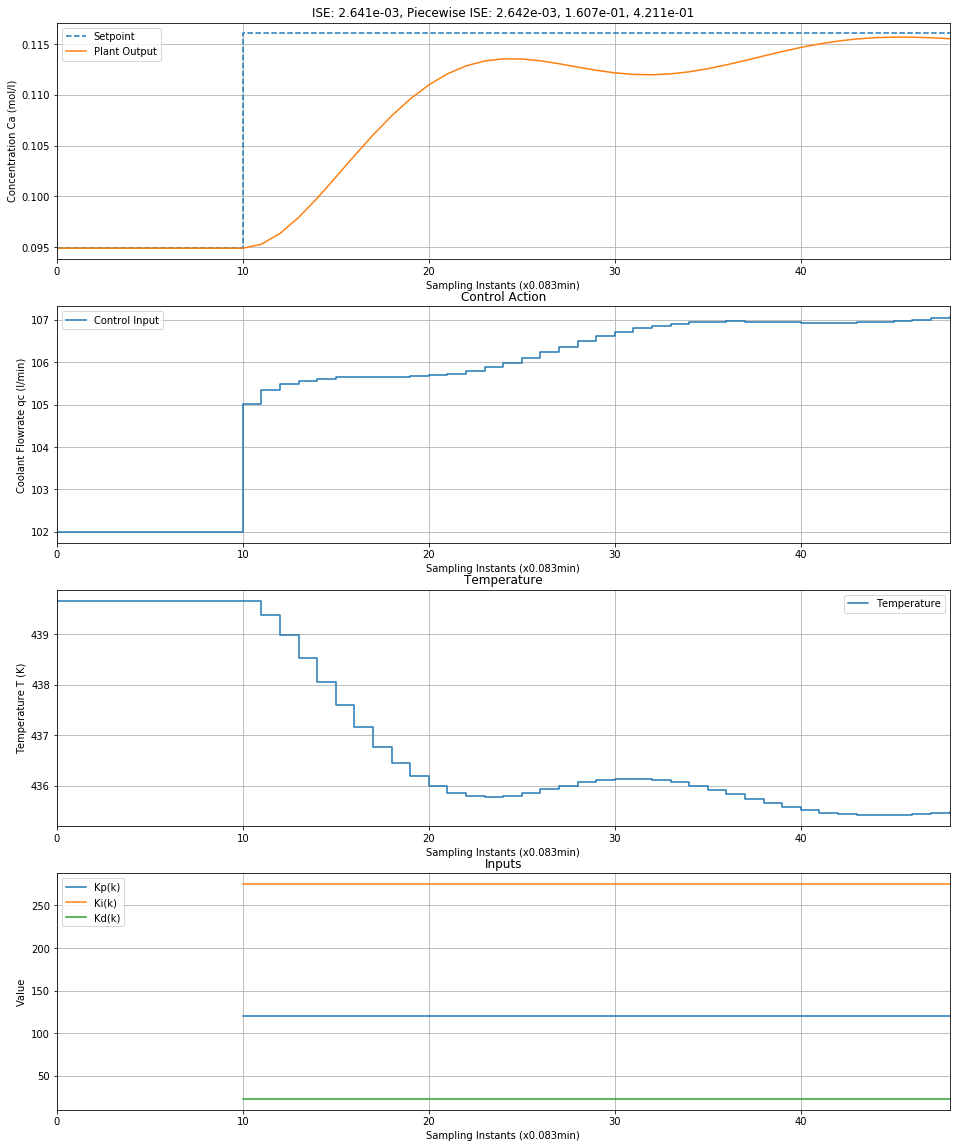

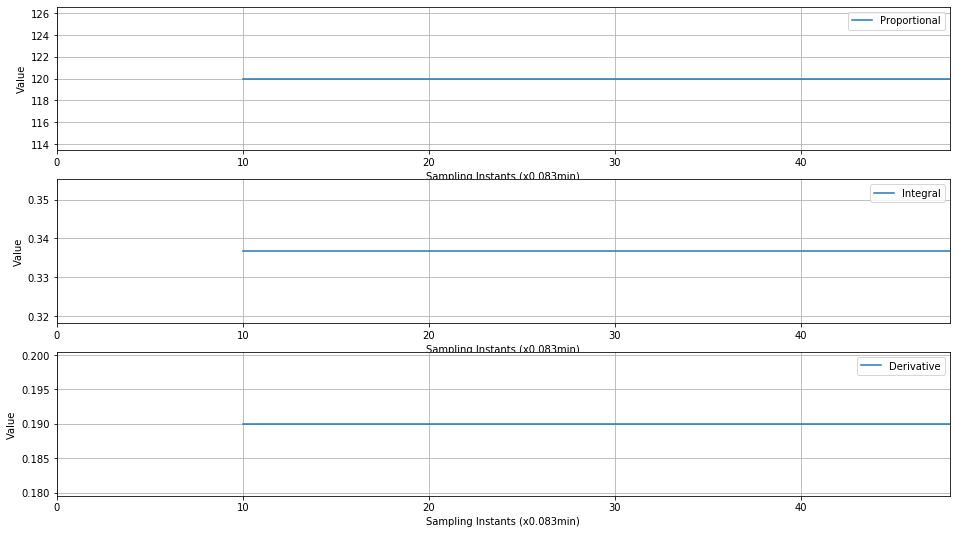

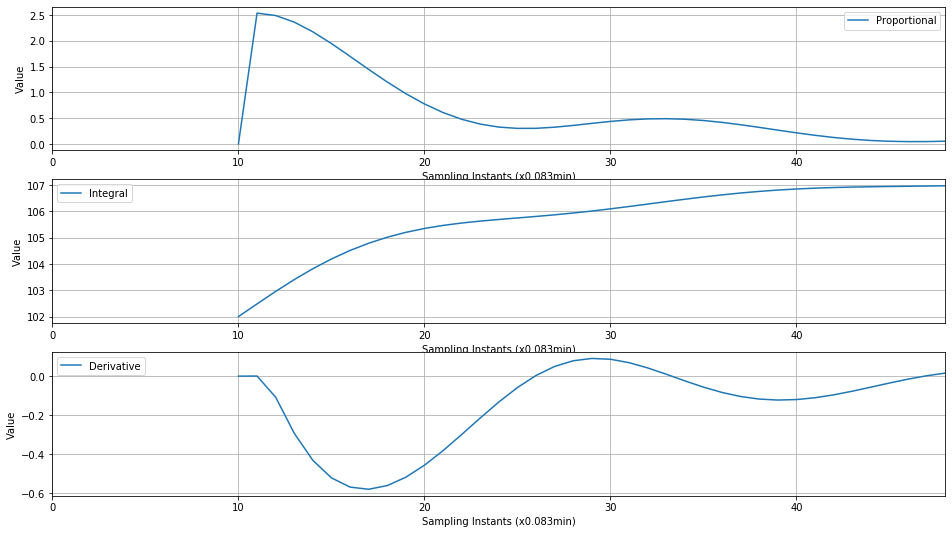

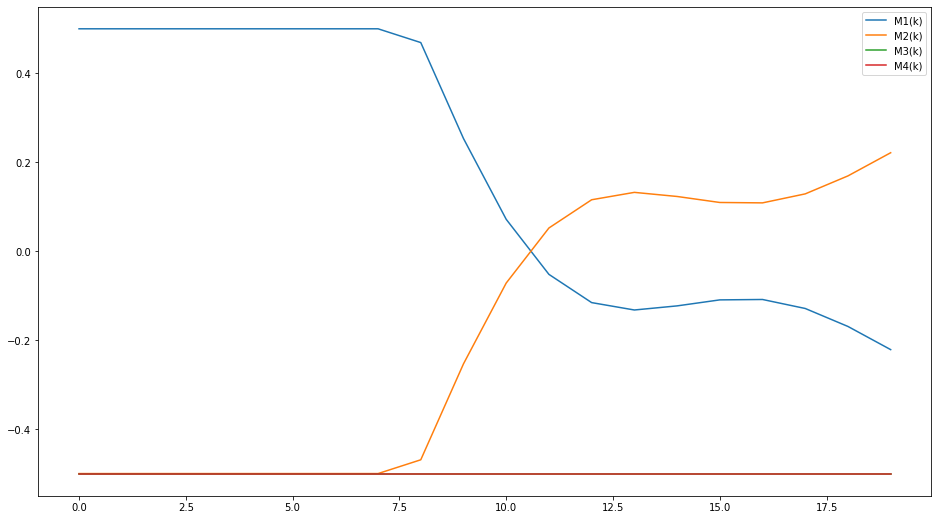

In [7]:
obs = env.reset()
obss = []
done = False
tot_r = 0
while not done:
#   obs, r, done, _ = env.step(env.action_space.sample())
  obs, r, done, _ = env.step(env.unconvert_action(np.array([Kp, taui, taud])))
  tot_r += r
  obss.append(obs)

print("Total Reward: ", tot_r)
env.render()
plt.show()
env.system.plot_gains()
env.system.plot_gain_components()
# img = env.render("rgb_array")
# # plt.imshow(img)
# im = Image.fromarray(img)
# path = os.path.join("", "test.png")
# im.save(path)
plt.show()
plt.figure(figsize=(16, 9))
lineObj = plt.plot(np.arange(len(obss)), obss)
plt.legend(lineObj, env.system.state_names)
plt.show()

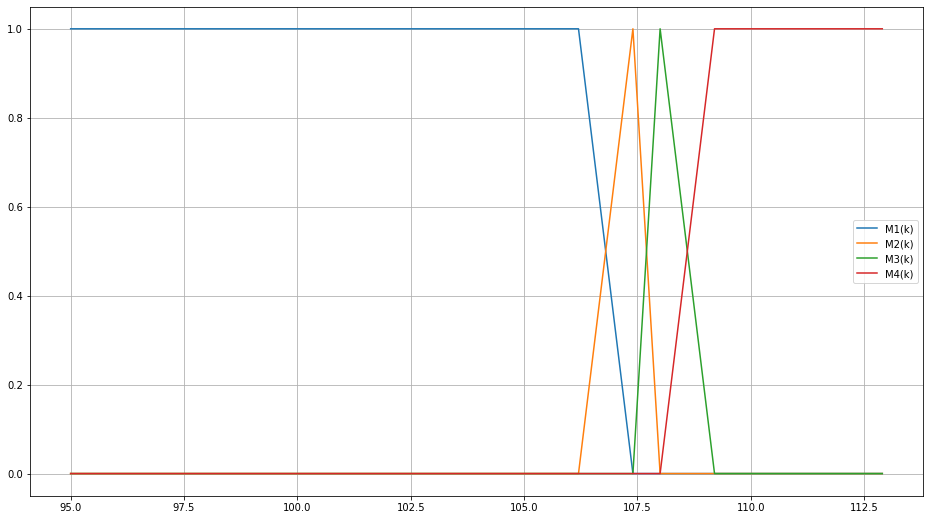

In [8]:
test_state = np.arange(95, 113, 0.1)
fuzz_v = []
for element in test_state:
    fuzz_v.append(env.system.fuzzify(element))

plt.figure(figsize=(16, 9))
lineObj = plt.plot(test_state, fuzz_v)
plt.legend(lineObj, env.system.state_names)
plt.grid()
plt.show()

In [9]:
import os
import cv2
import io
import numpy as np
from PIL import Image
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq, log_dir, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.env_save_path = os.path.join(log_dir, "vec_normalize.pkl")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        "Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(
                            self.best_mean_reward, mean_reward
                        )
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model at {} timesteps".format(x[-1]))
                        print(f"Saving new best model to {self.save_path}.zip")
                        print(f"Saving new env to {self.env_save_path}")
                    self.model.save(self.save_path)
                    self.model.env.save(self.env_save_path)

        return True



class SaveImageCallback(BaseCallback):
    """
    Callback for saving the setpoint tracking plot(the check is done every ``eval_freq`` steps)

    :param eval_env: (gym.Env) The environment used for initialization
    :param n_eval_episodes: (int) The number of episodes to test the agent
    :param eval_freq: (int) Evaluate the agent every eval_freq call of the callback.
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, eval_env, eval_freq=10000, log_dir=None, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.save_path = None
        if log_dir is not None:
            self.log_dir = log_dir
            self.save_path = os.path.join(log_dir, "images")

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            obs = self.eval_env.reset()
            obss = [obs]
            norm_obss = [self.model.env.normalize_obs(obs)]
            done = False
            tot_r = 0.0
            while not done:
                action, _ = self.model.predict(self.model.env.normalize_obs(obs), deterministic=True)
                obs, reward, done, info = self.eval_env.step(action)
                obss.append(obs)
                norm_obss.append(self.model.env.normalize_obs(obs))
                tot_r += reward
            obss = np.array(obss)
            norm_obss = np.array(norm_obss)
            print("Evaluation Reward: ", tot_r)
            if self.save_path is not None:
                eval_img = self.eval_env.render("rgb_array")
                im = Image.fromarray(eval_img)
                path = os.path.join(self.save_path, f"{str(self.model.num_timesteps).zfill(7)}.png")
                im.save(path)
                
                eval_img = self.eval_env.system.plot_gains(save=True)
                im = Image.fromarray(eval_img)
                path = os.path.join(self.save_path, f"{str(self.model.num_timesteps).zfill(7)}_gains.png")
                im.save(path)
                
                axis, axis_name = self.eval_env.system.get_axis()
                plt.figure(figsize=(20, 9))
                labels = self.eval_env.system.state_names.copy()
                plt.subplot(2, 1, 1)
                lineObj = plt.plot(np.arange(len(obss)), obss)
                plt.legend(lineObj, labels)
                plt.ylabel("Value")
                plt.xlabel(axis_name)
                plt.xlim(axis[0], axis[-1])
                plt.grid()
                    
                plt.subplot(2, 1, 2)
                lineObj = plt.plot(np.arange(len(norm_obss)), norm_obss)
                plt.legend(lineObj, labels)
                plt.ylabel("Value")
                plt.xlabel(axis_name)
                plt.xlim(axis[0], axis[-1])
                plt.grid()
                
                plt.tight_layout()
                img = fig2data(plt.gcf())
                plt.close()
                im = Image.fromarray(img)
                path = os.path.join(self.save_path, f"{str(self.model.num_timesteps).zfill(7)}_inputs.png")
                im.save(path)

        return True


In [10]:
import os

import torch
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecCheckNan, VecNormalize

In [11]:
# env_args = {
#     'system': CSTRFuzzyPID,
#     'disturbance': True,
#     'deterministic': False,
# }
# eval_env_args = {
#     'system': CSTRFuzzyPID,
#     'disturbance': False,
#     'deterministic': True,
# }

# print("Environment Args: ", env_args)
# print("Evaluation Environment Args: ", eval_env_args)

In [17]:
torch.autograd.set_detect_anomaly(True)
print("CUDA Available: ", torch.cuda.is_available())

early_stopping = True
print("Using Early Stopping: ", early_stopping)

action_repeat = True
action_repeat_value = 2
print("Using Action Repeat: ", action_repeat, action_repeat_value)

use_sde = False
print("Using gSDE: ", use_sde)

algo = "PPO"
print("Algorithm: ", algo)
tol = 2e-4
print("Tol: ", tol)

tag_name = f"CSTRFuzzyPID3_{algo}_AR_{action_repeat}_{action_repeat_value}_lamda_{lamda}_use_sde_{use_sde}_ES_{early_stopping}_tol_{tol}"
print("Run Name: ", tag_name)

model_dir = "./models"
log_dir = os.path.join("./logs", tag_name)

CUDA Available:  True
Using Early Stopping:  True
Using Action Repeat:  True 2
Using gSDE:  False
Algorithm:  PPO
Tol:  0.0002
Run Name:  CSTRFuzzyPID3_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True_tol_0.0002


In [20]:
checkpoint_callback = CheckpointCallback(100000, model_dir, tag_name)
save_callback = SaveOnBestTrainingRewardCallback(check_freq=20000, log_dir=log_dir, verbose=1)

# eval_env = GymCSTR(system=CSTRFuzzyPID)
# eval_env = GymCSTR(system=CSTRFuzzyPID2)
eval_env = GymCSTR(system=CSTRFuzzyPID3)
if early_stopping: eval_env = EarlyStopping(eval_env, tol=tol)
if action_repeat: eval_env = ActionRepeat(eval_env, action_repeat_value)
save_image_callback = SaveImageCallback(eval_env=eval_env, eval_freq=50000, log_dir=log_dir)

callback = CallbackList([checkpoint_callback, save_callback, save_image_callback])
print(callback.callbacks)

[<stable_baselines3.common.callbacks.CheckpointCallback object at 0x7fbb1030be10>, <__main__.SaveOnBestTrainingRewardCallback object at 0x7fbb1030b278>, <__main__.SaveImageCallback object at 0x7fbb1030bfd0>]


[-0.16666667  0.16666667 -0.5        -0.5       ]
Evaluation Reward:  6.548418406437263
ISE:  0.00042202211504373927


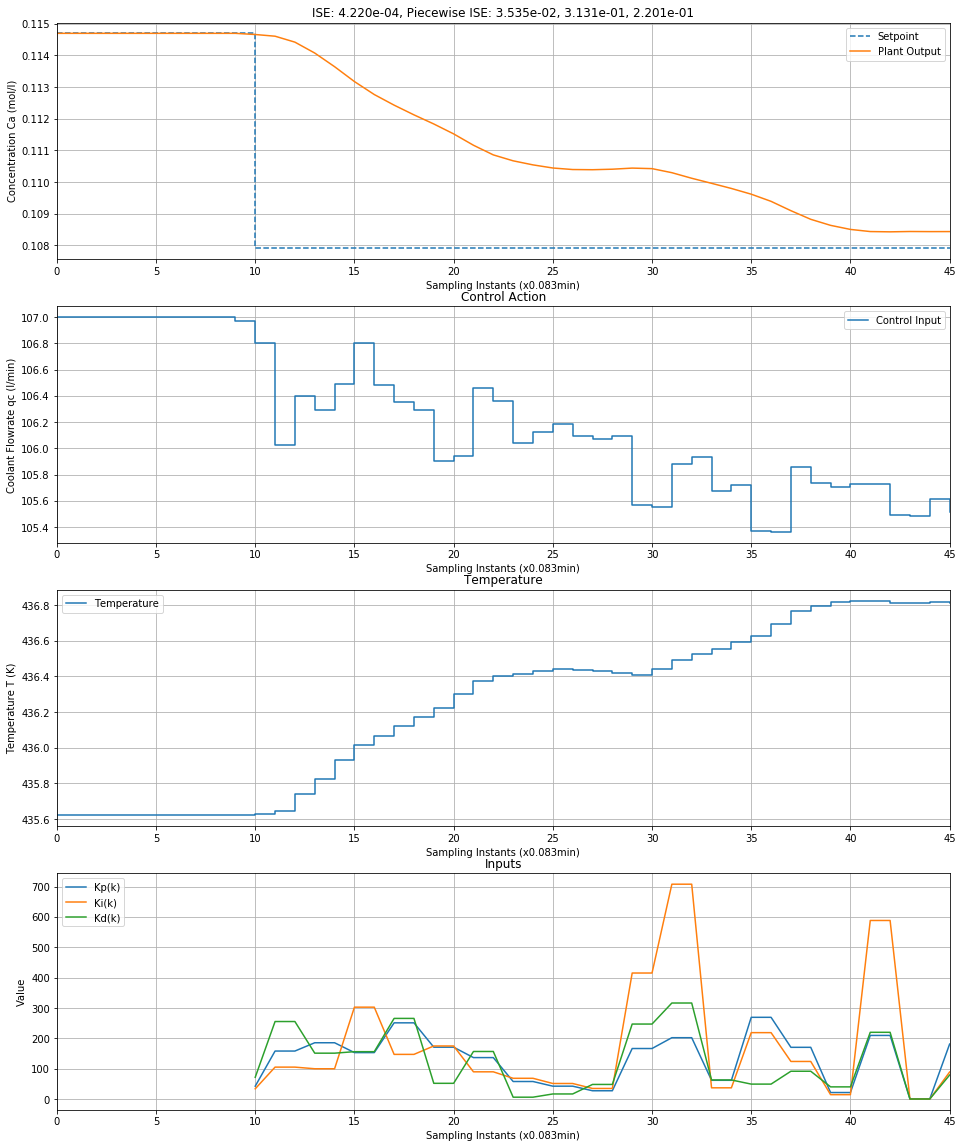

In [21]:
obs = eval_env.reset()
print(obs)
done = False
while not done:
    obs, reward, done, info = eval_env.step(eval_env.action_space.sample())
    tot_r += reward
print("Evaluation Reward: ", tot_r)
eval_env.render()

In [22]:
# env = GymCSTR(system=CSTRFuzzyPID)
# env = GymCSTR(system=CSTRFuzzyPID2)
env = GymCSTR(system=CSTRFuzzyPID3)
if early_stopping: env = EarlyStopping(env, tol=tol)
if action_repeat: env = ActionRepeat(env, action_repeat_value)
env = make_vec_env(lambda: env, n_envs=1, monitor_dir=log_dir)
if os.path.exists(os.path.join(log_dir, "vec_normalize.pkl")):
    print("Found VecNormalize Stats. Using stats")
    env = VecNormalize.load(os.path.join(log_dir, "vec_normalize.pkl"), env)
else:
    print("No previous stats found. Using new VecNormalize instance.")
    env = VecNormalize(env)
env = VecCheckNan(env, raise_exception=True)

if algo == "PPO":
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/", use_sde=use_sde)
elif algo == "SAC":
    model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/", use_sde=use_sde)
else:
    raise NotImplementedError()

best_model_path = os.path.join(log_dir, "best_model.zip")
if os.path.exists(best_model_path):
    print("Found previous checkpoint. Loading from checkpoint.")
    if algo == "PPO":
        model = PPO.load(best_model_path, env)
    elif algo == "SAC":
        model = SAC.load(best_model_path, env)
    else:
        raise NotImplementedError()
print(model)

No previous stats found. Using new VecNormalize instance.
Using cuda device


In [26]:
# test_env = GymCSTR(system=CSTRFuzzyPID)
# test_env = GymCSTR(system=CSTRFuzzyPID2)
test_env = GymCSTR(system=CSTRFuzzyPID3)
if early_stopping: test_env = EarlyStopping(test_env, tol=tol)
if action_repeat: test_env = ActionRepeat(test_env, action_repeat_value)

Evaluation Reward:  -1.01464342611587
ISE:  0.0009731365797089441


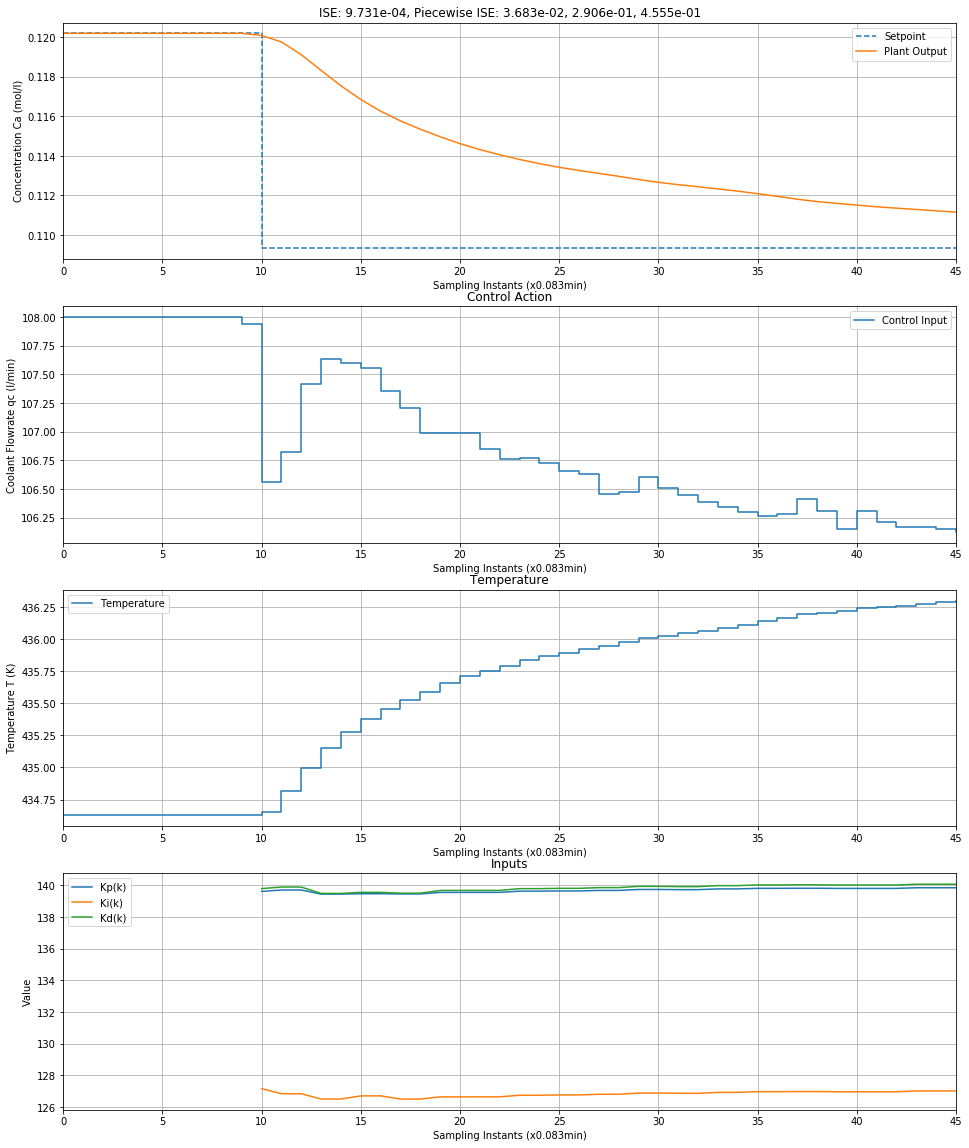

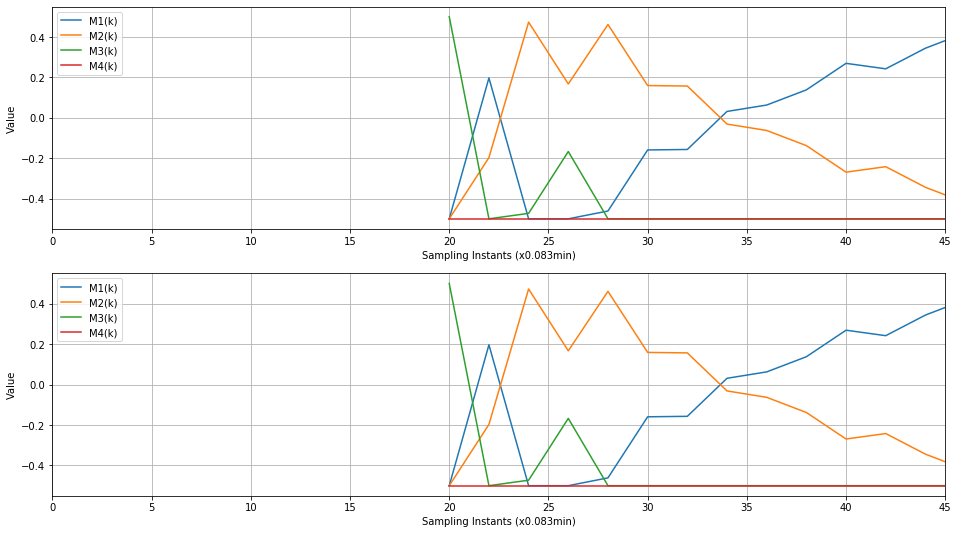

In [27]:
obs = test_env.reset()
obss = [obs]
norm_obss = [model.env.normalize_obs(obs)]
done = False
tot_r = 0.0
stepss = 0
while not done:
  action, _ = model.predict(model.env.normalize_obs(obs), deterministic=True)
  obs, reward, done, info = test_env.step(action)
  obss.append(obs)
  norm_obss.append(model.env.normalize_obs(obs))
  tot_r += reward
  stepss += 1
print("Evaluation Reward: ", tot_r)
test_env.render()
# test_env.system.plot_gains()
plt.show()
axis, axis_name = test_env.system.get_axis()
plt.figure(figsize=(16, 9))
labels = test_env.system.state_names.copy()
obss = np.array(obss)
norm_obss = np.array(norm_obss)
plt.subplot(2, 1, 1)
lineObj = plt.plot(axis[test_env.system.ksp: test_env.system.ksp+len(obss)]*action_repeat_value, obss)
plt.legend(lineObj, labels)
plt.ylabel("Value")
plt.xlabel(axis_name)
plt.xlim(axis[0], axis[-1])
plt.grid()

plt.subplot(2, 1, 2)
lineObj = plt.plot(axis[test_env.system.ksp: test_env.system.ksp+len(norm_obss)]*action_repeat_value, norm_obss)
plt.legend(lineObj, labels)
plt.ylabel("Value")
plt.xlabel(axis_name)
plt.xlim(axis[0], axis[-1])
plt.grid()

In [ ]:
tsteps = 2_000_000
model.learn(tsteps, reset_num_timesteps=False, callback=callback, tb_log_name=tag_name)

Logging to ./tensorboard/CSTRFuzzyPID3_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True_tol_0.0002_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | -0.48    |
| time/              |          |
|    fps             | 330      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.9        |
|    ep_rew_mean          | -0.681      |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011680701 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_los

Evaluation Reward:  7.554753002662215
ISE:  0.0026371592038199783


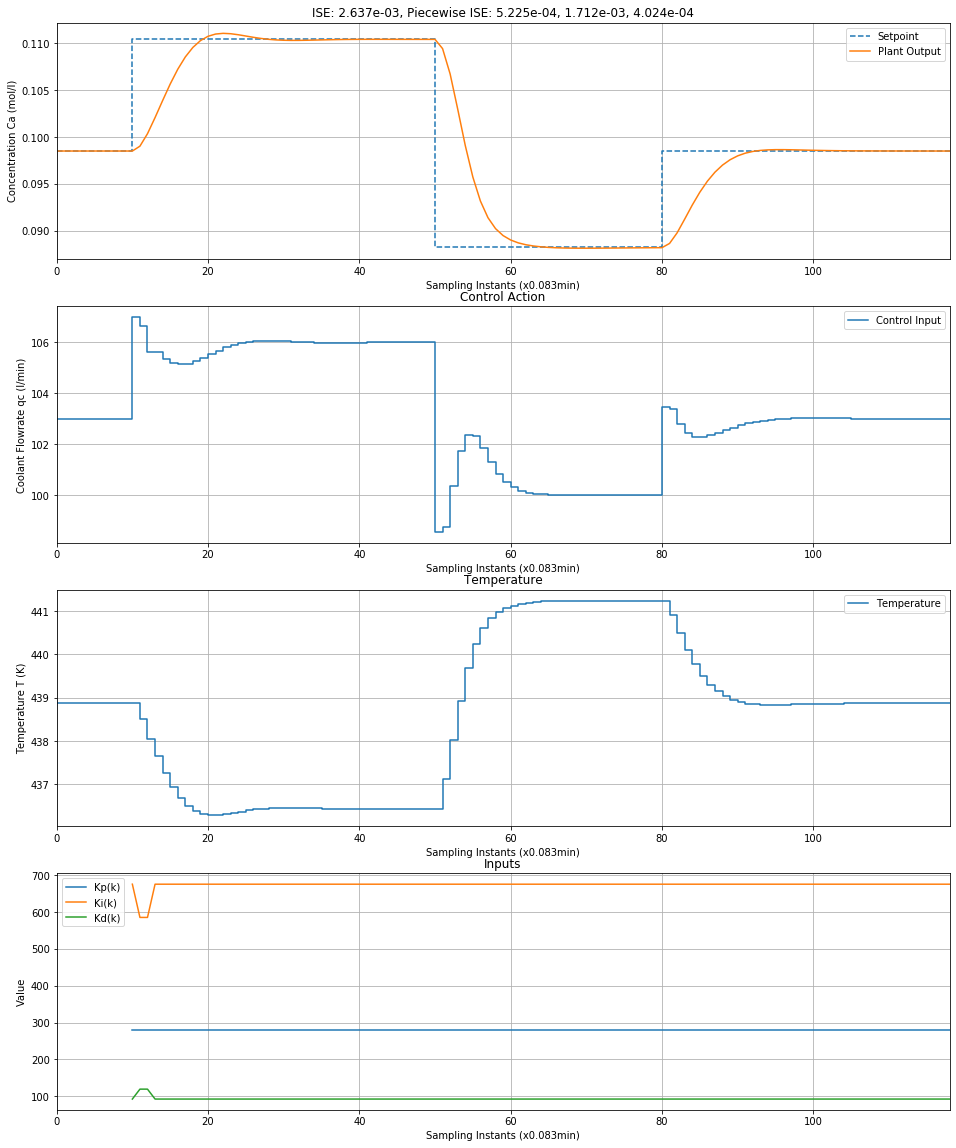

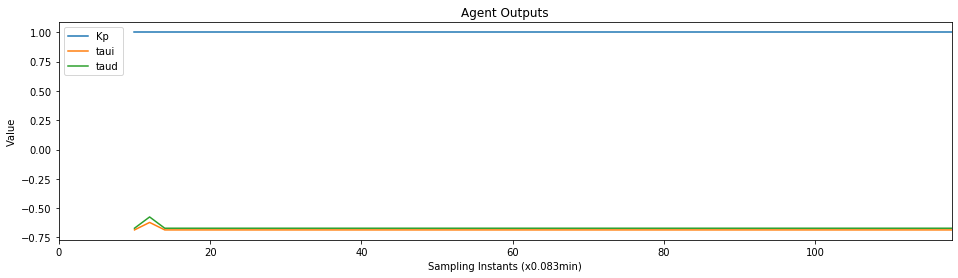

Text(0.5, 1.0, 'Normalized States')

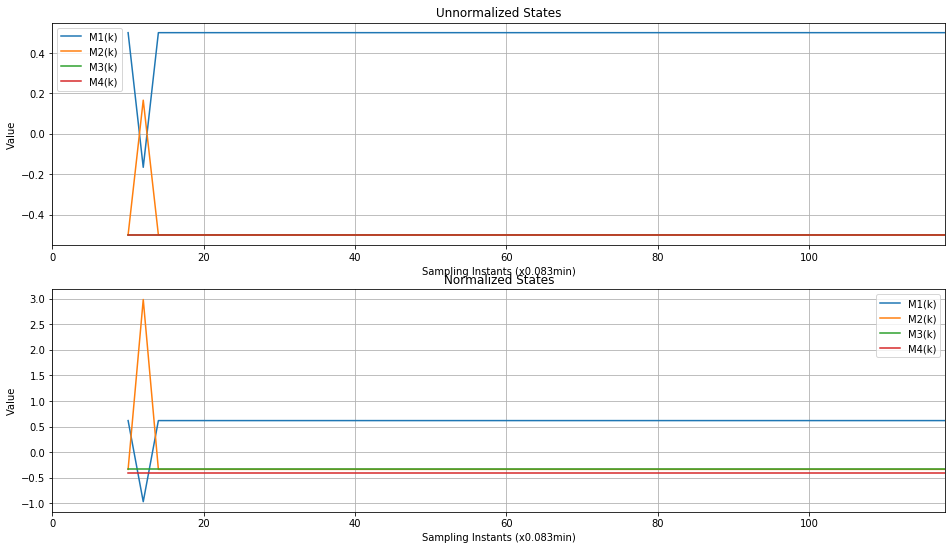

In [16]:
test_env = GymCSTR(
#     system=CSTRFuzzyPID,
#     system=CSTRFuzzyPID2,
    system=CSTRFuzzyPID3,
    disturbance=False,
    deterministic=True
)
if action_repeat: test_env = ActionRepeat(test_env, action_repeat_value)
obs = test_env.reset()
obss = [obs]
norm_obss = [model.env.normalize_obs(obs)]
actions = []
done = False
tot_r = 0.0
while not done:
    action, _ = model.predict(model.env.normalize_obs(obs), deterministic=True)
    obs, reward, done, info = test_env.step(action)
    obss.append(obs)
    norm_obss.append(model.env.normalize_obs(obs))
    actions.append(action)
    tot_r += reward
print("Evaluation Reward: ", tot_r)
test_env.render()
# test_env.system.plot_gains()
plt.show()
axis, axis_name = test_env.system.get_axis()
labels = test_env.system.state_names.copy()
obss = np.array(obss)
norm_obss = np.array(norm_obss)

plt.figure(figsize=(16, 4))
lineObj = plt.plot(axis[test_env.system.ksp::action_repeat_value], actions)
plt.legend(lineObj, ["Kp", "taui", "taud"])
plt.ylabel("Value")
plt.xlabel(axis_name)
plt.xlim(axis[0], axis[-1])
plt.title("Agent Outputs")
plt.show()

plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
lineObj = plt.plot(axis[test_env.system.ksp::action_repeat_value], obss[:-1])
plt.legend(lineObj, labels)
plt.ylabel("Value")
plt.xlabel(axis_name)
plt.xlim(axis[0], axis[-1])
plt.grid()
plt.title("Unnormalized States")

plt.subplot(2, 1, 2)
lineObj = plt.plot(axis[test_env.system.ksp::action_repeat_value], norm_obss[:-1])
plt.legend(lineObj, labels)
plt.ylabel("Value")
plt.xlabel(axis_name)
plt.xlim(axis[0], axis[-1])
plt.grid()
plt.title("Normalized States")

In [47]:
values = np.arange(0, test_env.n_states)
n_values = np.max(values) + 1
regions = np.eye(n_values)[values]
regions = regions - 0.5

for i, region in enumerate(regions):
    action, _ = model.predict(model.env.normalize_obs(region), deterministic=True)
    action = test_env.convert_action(action)
    print(test_env.system.state_names[i])
    print('Kp: %.3f, TauI: %.3f, TauD: %.3f' % (action[0], action[1], action[2]))

M1(k)
Kp: 280.000, TauI: 0.314, TauD: 0.329
M2(k)
Kp: 280.000, TauI: 0.377, TauD: 0.463
M3(k)
Kp: 235.931, TauI: 0.308, TauD: 0.390
M4(k)
Kp: 270.898, TauI: 0.402, TauD: 0.432


In [76]:
action, _ = model.predict(model.env.normalize_obs([1.0, 0.0, 0.0, 0.0, 0.0]), deterministic=True)
print(test_env.convert_action(action))
action, _ = model.predict(model.env.normalize_obs([0.0, 1.0, 0.0, 0.0, 0.0]), deterministic=True)
print(test_env.convert_action(action))
action, _ = model.predict(model.env.normalize_obs([0.0, 0.0, 1.0, 0.0, 0.0]), deterministic=True)
print(test_env.convert_action(action))
action, _ = model.predict(model.env.normalize_obs([0.0, 0.0, 0.0, 1.0, 0.0]), deterministic=True)
print(test_env.convert_action(action))
action, _ = model.predict(model.env.normalize_obs([0.0, 0.0, 0.0, 0.0, 1.0]), deterministic=True)
print(test_env.convert_action(action))

[12.30821729  2.          0.8651315 ]
[197.18406916   0.27172291   0.39336437]
[263.33666801   0.69289625   0.30534756]
[263.39871883   0.31949043   0.43822056]
[151.5331912    1.69321239   0.25369781]


In [1]:
# !apt-get update
# !apt-get install zip unzip
!zip -r logs.zip ./logs
!zip -r tensorboard.zip ./tensorboard

  adding: logs/ (stored 0%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/ (stored 0%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/best_model/ (stored 0%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/images/ (stored 0%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/images/.ipynb_checkpoints/ (stored 0%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/images/.ipynb_checkpoints/0700000-checkpoint.png (deflated 14%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/images/.ipynb_checkpoints/0750000-checkpoint.png (deflated 11%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/images/.ipynb_checkpoints/0850000-checkpoint.png (deflated 11%)
  adding: logs/CSTRFuzzyPID2_PPO_AR_True_2_lamda_0.5_use_sde_False_ES_True/images/.ipynb_checkpoints/1900000_inputs-checkpoint.png (deflated 4%)
  adding: logs